# Kaggle Playground Series S-5 ep-4

### Dependencies

In [85]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

In [86]:
sns.set_theme(style = "darkgrid")
warnings.filterwarnings("ignore")

### Preparing the Dataframe

In [87]:
df = pd.read_csv(os.path.join("Data","train.csv"))
df.set_index(df["id"],inplace=True)
df.drop(columns = ["id","Episode_Title","Publication_Day","Publication_Time","Podcast_Name"],inplace=True)
df.head()

,Episode_Length_minutes,Genre,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,
0,NaN,True Crime,74.81,NaN,0.0,Positive,31.41998
1,119.80,Comedy,66.95,75.95,2.0,Negative,88.01241
2,73.90,Education,69.97,8.97,0.0,Negative,44.92531
3,67.17,Technology,57.22,78.70,2.0,Positive,46.27824
4,110.51,Health,80.07,58.68,3.0,Neutral,75.61031


In [88]:
print(df.isna().sum())
df["Episode_Length_minutes"].fillna(df["Episode_Length_minutes"].mean(),inplace=True)
df["Guest_Popularity_percentage"].fillna(df["Guest_Popularity_percentage"].mean(),inplace=True)
df["Number_of_Ads"].fillna(0,inplace=True)
print("==============================================")
print(df.isna().sum())

Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


In [89]:
print(df.dtypes)
print("========================")
df["Genre"] = df["Genre"].astype("str")
df["Episode_Sentiment"] = df["Episode_Sentiment"].astype("str")

print(df.dtypes)

Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object


In [90]:
sameple_df = df.sample(n = 5000)
sameple_df.head()

,Episode_Length_minutes,Genre,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,
376142,113.570000,Technology,30.62,5.440000,1.0,Positive,67.06905
375522,108.150000,Business,56.15,52.236449,0.0,Positive,96.16184
474347,109.720000,Comedy,48.39,55.160000,3.0,Neutral,69.30263
407664,64.504738,Sports,53.33,52.236449,0.0,Neutral,74.60156
385722,34.570000,Lifestyle,91.02,77.200000,2.0,Neutral,26.09202


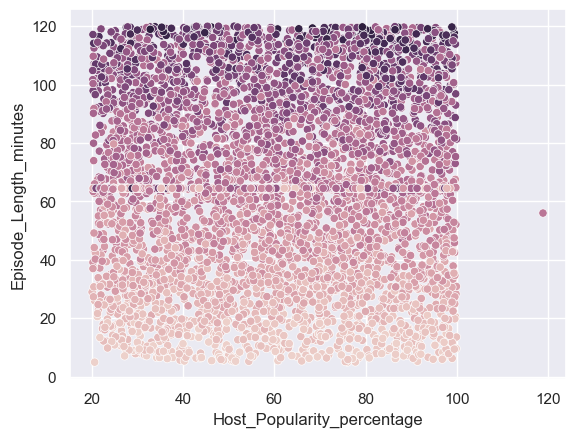

In [91]:
sns.scatterplot(data=sameple_df,x = "Host_Popularity_percentage",y = "Episode_Length_minutes",hue = "Listening_Time_minutes",legend=False)
plt.show()

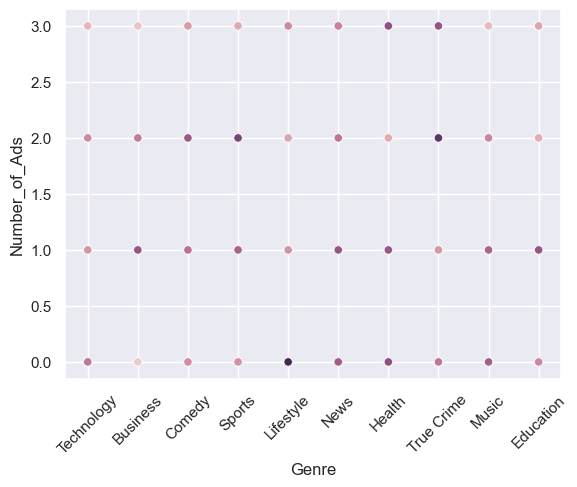

In [92]:
sns.scatterplot(data=sameple_df,x = "Genre",y = "Number_of_Ads",hue = "Listening_Time_minutes",legend=False)
plt.xticks(rotation = 45)
plt.show()

### Preprocessing

In [93]:
genre_columns = df["Genre"].unique()
ep_sentiment_columns = df["Episode_Sentiment"].unique()


print(f"Genre Columns: {genre_columns}")
print("=======================================")
print(f"Episode Sentiment Columns: {ep_sentiment_columns}")

Genre Columns: ['True Crime' 'Comedy' 'Education' 'Technology' 'Health' 'News' 'Music'
 'Sports' 'Business' 'Lifestyle']
Episode Sentiment Columns: ['Positive' 'Negative' 'Neutral']


In [94]:
def Preprocessing(df):
    genre_df = pd.get_dummies(df["Genre"],prefix="Genre_",dtype="float")
    ep_sentiment_df = pd.get_dummies(df["Episode_Sentiment"],prefix="Episode_Sentiment_",dtype="int")

    df = pd.concat([df,genre_df],axis = 1)
    df = pd.concat([df,ep_sentiment_df],axis = 1)

    df.drop(columns = ["Genre","Episode_Sentiment"],inplace=True)
    return df

In [95]:
preprocessed_df = Preprocessing(df)
preprocessed_df.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Genre__Business,Genre__Comedy,Genre__Education,Genre__Health,Genre__Lifestyle,Genre__Music,Genre__News,Genre__Sports,Genre__Technology,Genre__True Crime,Episode_Sentiment__Negative,Episode_Sentiment__Neutral,Episode_Sentiment__Positive
id,,,,,,,,,,,,,,,,,,
0,64.504738,74.81,52.236449,0.0,31.41998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1
1,119.800000,66.95,75.950000,2.0,88.01241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,73.900000,69.97,8.970000,0.0,44.92531,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,67.170000,57.22,78.700000,2.0,46.27824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
4,110.510000,80.07,58.680000,3.0,75.61031,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


### Splitting the Data

In [106]:
X = preprocessed_df.drop(columns = ["Listening_Time_minutes"]).values
y = preprocessed_df["Listening_Time_minutes"].values

In [107]:
y = y.astype("float")

In [109]:
print("X type:", type(X))
print("X dtype:", X.dtype)
print("First row of X:", X[0])

X type: <class 'numpy.ndarray'>
X dtype: float64
First row of X: [64.50473835 74.81       52.23644893  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          1.        ]


In [111]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=69)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (600000, 17)
y_train Shape: (600000,)
X_test Shape: (150000, 17)
y_test Shape: (150000,)


### Building the Model

In [139]:
reg = xgb.XGBRegressor(n_estimators = 10000,
                       max_depth = 5,
                       learning_rate = 0.0001,
                       objective = "reg:squarederror",
                       verbose = 3,eval_metric = "rmse")

In [142]:
eval_set = [(X, y)]

In [143]:
reg.fit(X,y,eval_set=eval_set)

[0]	validation_0-rmse:27.13623
[1]	validation_0-rmse:27.13418
[2]	validation_0-rmse:27.13213
[3]	validation_0-rmse:27.13007
[4]	validation_0-rmse:27.12802
[5]	validation_0-rmse:27.12597
[6]	validation_0-rmse:27.12392
[7]	validation_0-rmse:27.12186
[8]	validation_0-rmse:27.11981
[9]	validation_0-rmse:27.11776
[10]	validation_0-rmse:27.11571
[11]	validation_0-rmse:27.11366
[12]	validation_0-rmse:27.11161
[13]	validation_0-rmse:27.10956
[14]	validation_0-rmse:27.10751
[15]	validation_0-rmse:27.10546
[16]	validation_0-rmse:27.10341
[17]	validation_0-rmse:27.10136
[18]	validation_0-rmse:27.09931
[19]	validation_0-rmse:27.09726
[20]	validation_0-rmse:27.09521
[21]	validation_0-rmse:27.09316
[22]	validation_0-rmse:27.09111
[23]	validation_0-rmse:27.08907
[24]	validation_0-rmse:27.08702
[25]	validation_0-rmse:27.08497
[26]	validation_0-rmse:27.08292
[27]	validation_0-rmse:27.08088
[28]	validation_0-rmse:27.07883
[29]	validation_0-rmse:27.07678
[30]	validation_0-rmse:27.07474
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

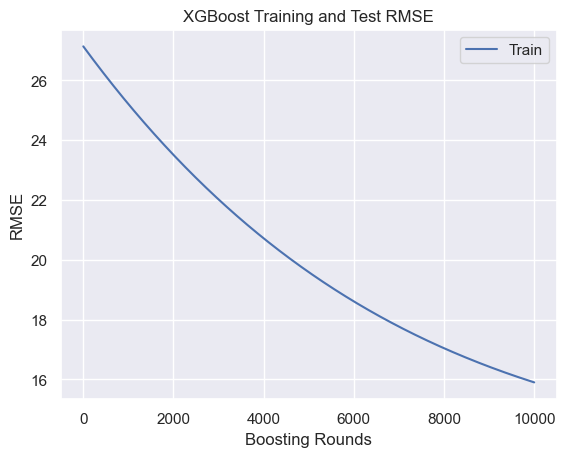

In [145]:
eval_res = reg.evals_result_
x_axis = range(0, 10000)
plt.plot(x_axis, eval_res['validation_0']["rmse"], label='Train')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('XGBoost Training and Test RMSE')
plt.show()

In [146]:
mean_y = y.mean()
std_y = y.std()
print(f"Mean of Target: {mean_y}")
print(f"Standard Deviation of Target: {std_y}")


Mean of Target: 45.43740628813335
Standard Deviation of Target: 27.138287735761345


In [147]:
reg.save_model('v-1.bin')